# Fish Market Weight Analysis - Regression Modelling

![Alt Text](https://images.unsplash.com/photo-1611214774777-3d997a9d0e35?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZmlzaCUyMG1hcmtldHxlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80)


# Import stuff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import optuna

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading and Info

In [2]:
df = pd.read_csv('/kaggle/input/fish-market/Fish.csv')

df2 = pd.read_csv('/kaggle/input/fish-market/Fish.csv')

df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


## Info

* 7 cols, 1 cat, 6 numerical
* Weight as label, 6 features
* no null values, check duplicates?
* unique species? balanced dataset?
* check distribution of numericals

In [4]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


## Describe

* Weight min of 0? need to clean
* length mean +- std looks decent, not like the weight data mistake
* same for height and width, guess we have to check and atleast remove the 0 weight

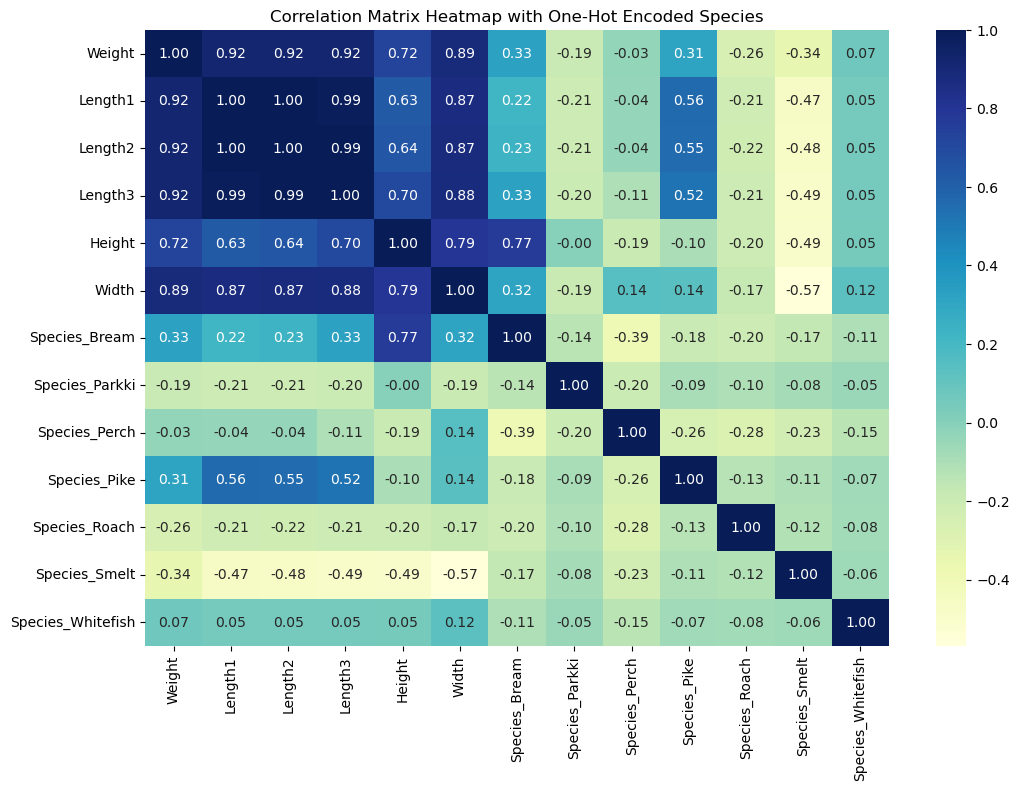

In [5]:
# OHE to show cat feature
df_encoded = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

## corrmatrix

* high corr between different lengths, all fishs seems to have the same shape?
* all numerical features highly correlated with weight, height with the lowest, but still at 0.72
* Bream and Pike highest correlations, heaviest fish, Roach and Smelt large negative, lightest fish

In [6]:
df.groupby('Species').agg({'Weight':'mean'}).sort_values(by = 'Weight')

,Weight
Species,
Smelt,11.178571
Roach,152.050000
Parkki,154.818182
Perch,382.239286
Whitefish,531.000000
Bream,617.828571
Pike,718.705882


Yep, turns out Smelt is by far the lightest and pike the heaviest fish

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


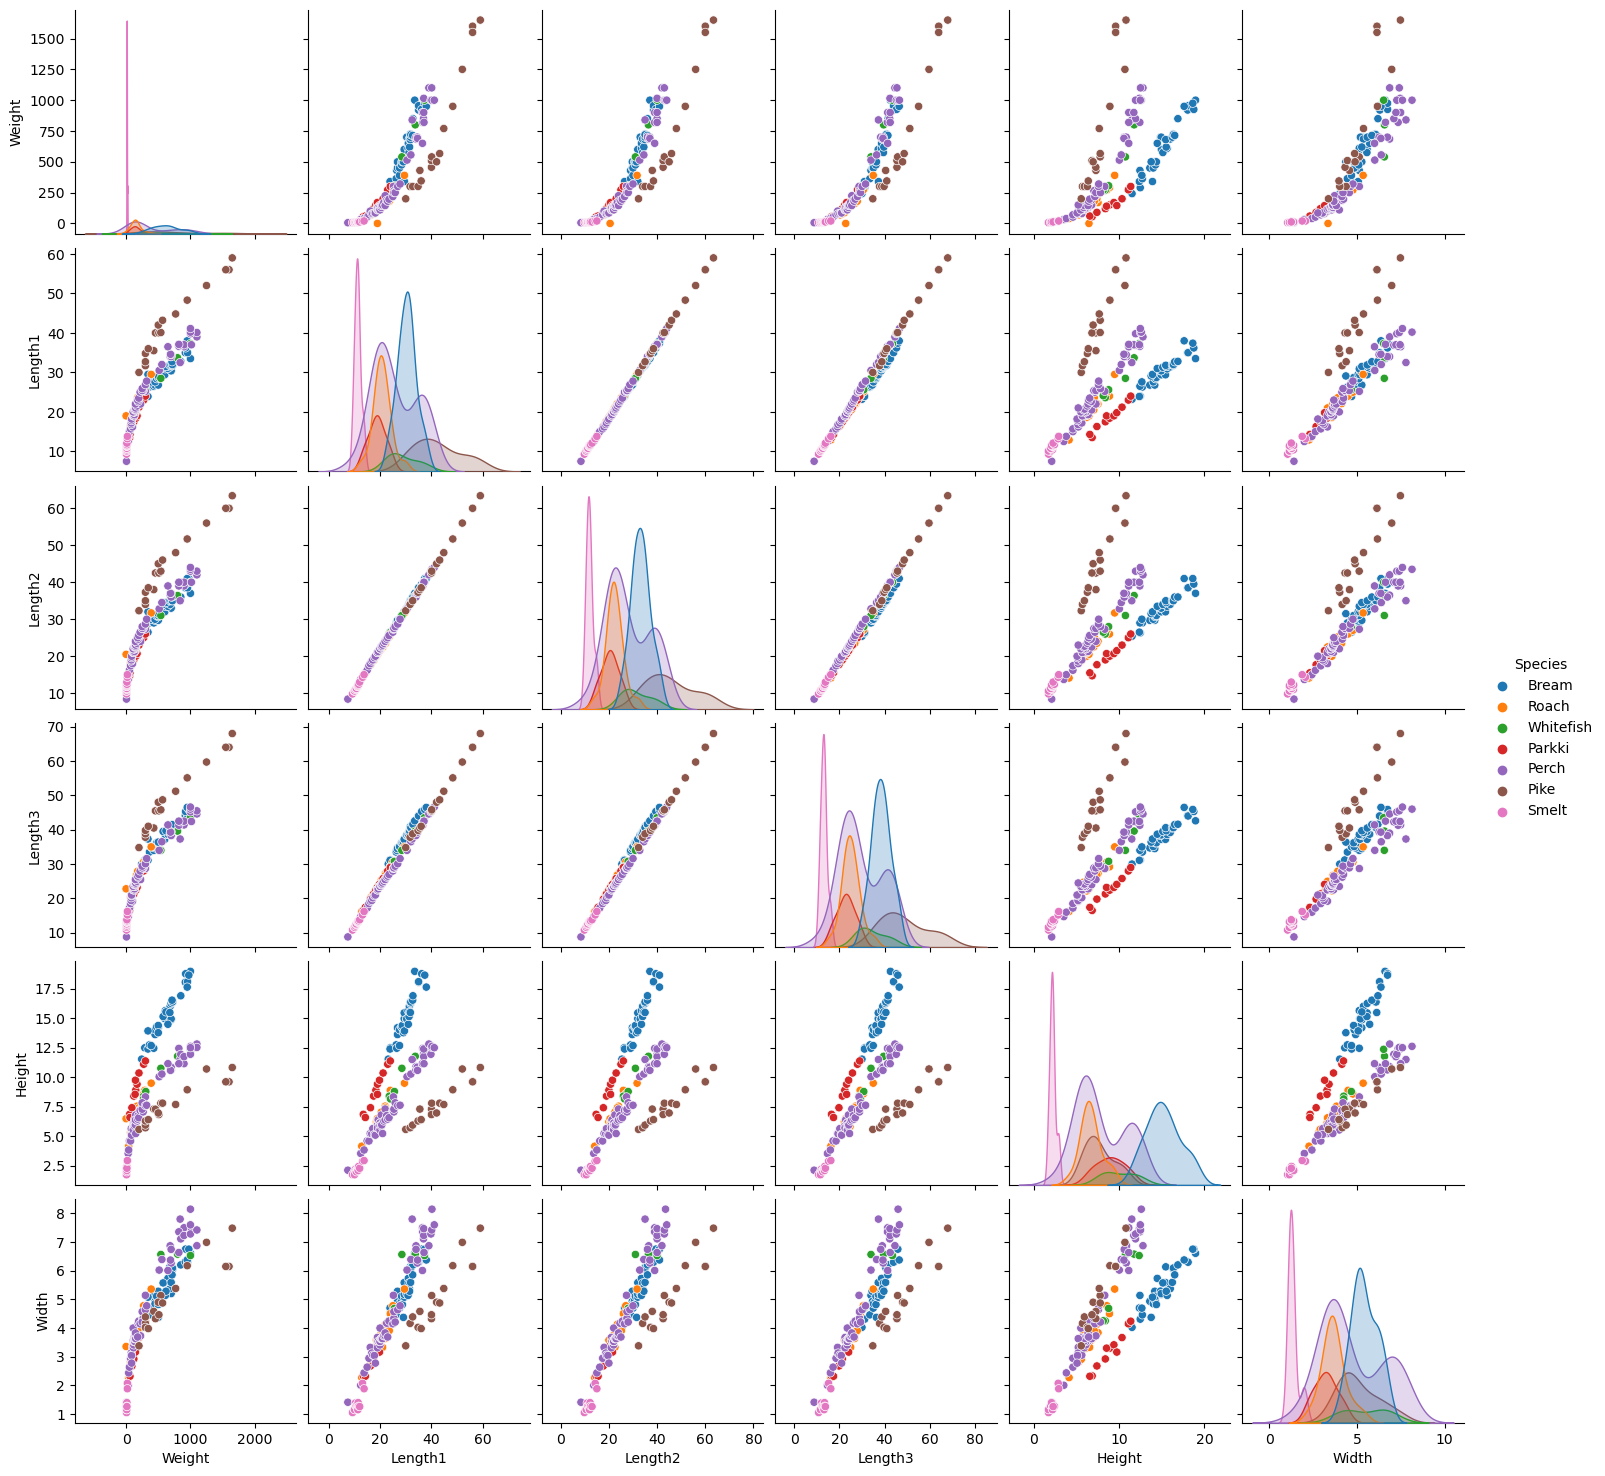

In [7]:
sns.pairplot(data = df , hue = 'Species');

## Pairplot

* multicollinearity, backs up results from corr_matrix
* many strong linear relations, but some non-linear relations, maybe LinearRegression wont be the best model choice, we'll see

# Cleaning + Engi

## Feature Reduction

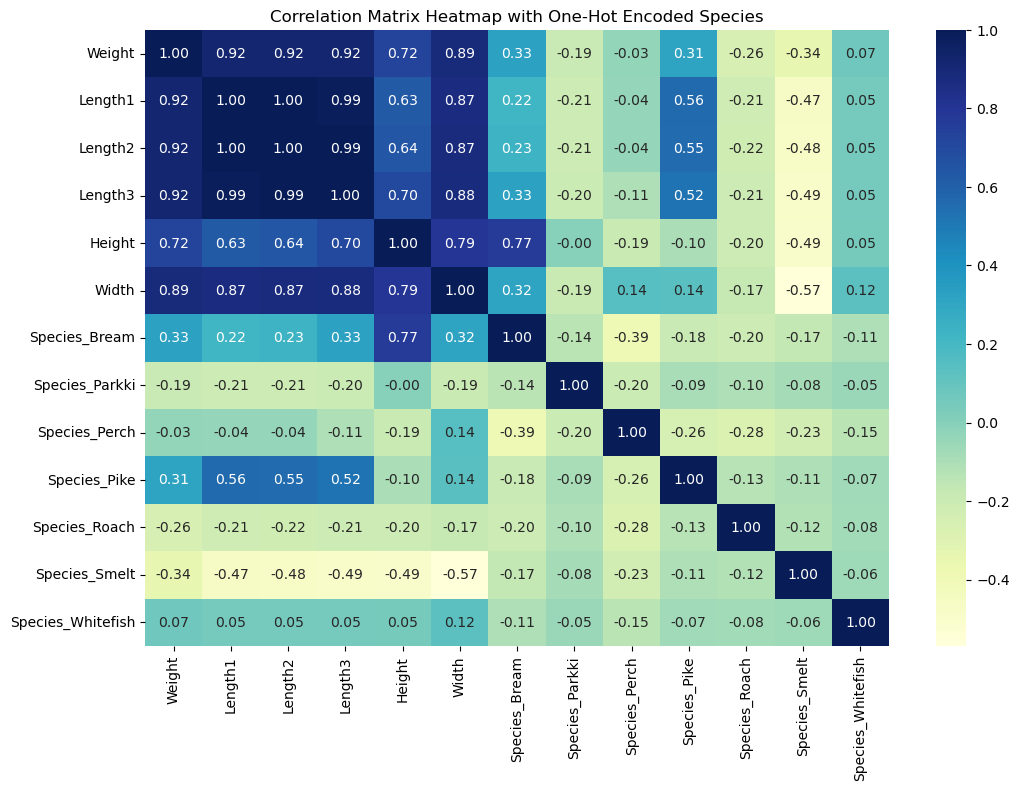

In [8]:
# OHE to show cat feature
df_encoded = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

In [9]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# find the fish with weight 0
print(df[df['Weight'] == 0])

# remove from the dataset
df = df[df['Weight'] != 0]

# only keep correlated features
df = df[["Weight", "Length1", "Height"]]

df.head()

   Species  Weight  Length1  Length2  Length3  Height   Width
40   Roach     0.0     19.0     20.5     22.8  6.4752  3.3516


,Weight,Length1,Height
0,242.0,23.2,11.5200
1,290.0,24.0,12.4800
2,340.0,23.9,12.3778
3,363.0,26.3,12.7300
4,430.0,26.5,12.4440


# Model

## Polynomial Regression

Coefficients: [  0.         -31.46355954   8.36448448   0.23309248   5.03391958
  -5.71959283]

Intercept: 208.99792296697893

Mean Squared Error (MSE): 5152.17532460147

R-squared (R^2): 0.9616198726750707

Mean Absolute Error (MAE): 43.01995306228792


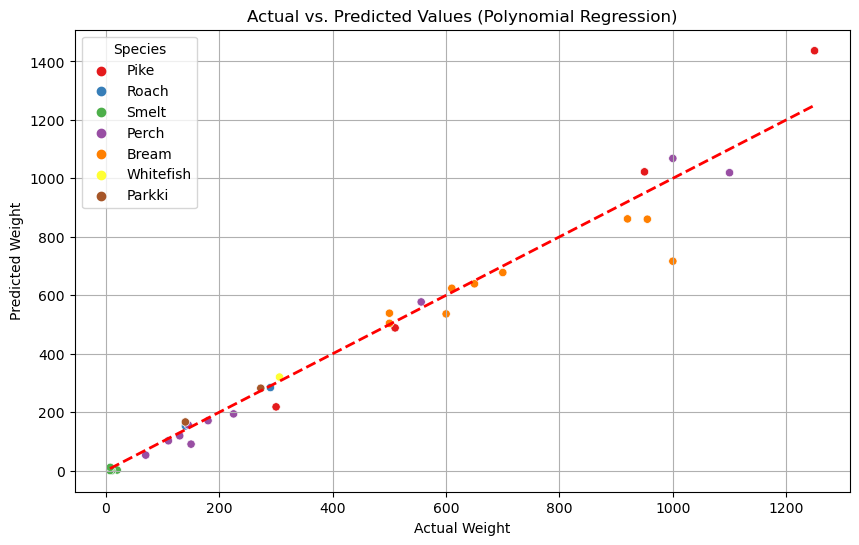

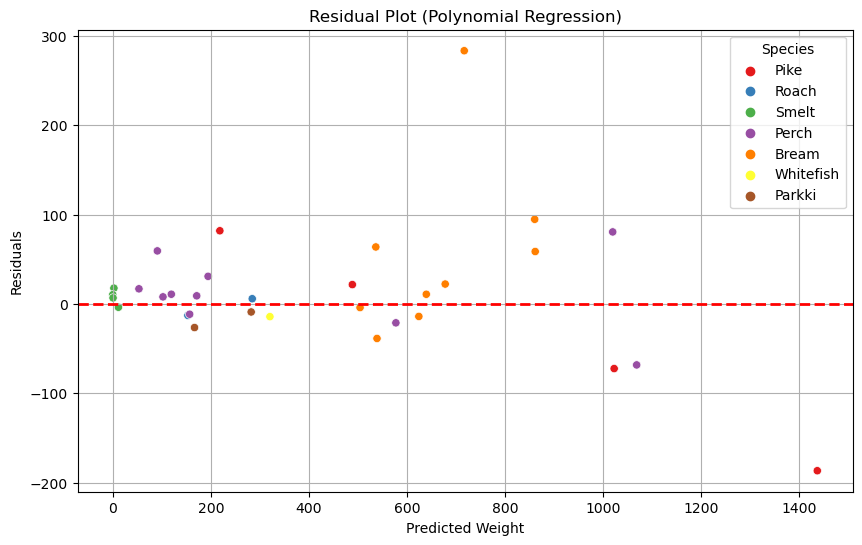

In [10]:
# label and features
X = df[["Length1", "Height"]]
y = df['Weight']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# poly transform
poly_features = PolynomialFeatures(degree=2)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

# fit
polylr = LinearRegression()
polylr.fit(X_poly_train, y_train)

# predict
y_pred = polylr.predict(X_poly_test)

# coefficients
print("Coefficients:", polylr.coef_)
print("\nIntercept:", polylr.intercept_)

# metrics
print("\nMean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("\nR-squared (R^2):", r2_score(y_test, y_pred))
print("\nMean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

# merge species to get seaborn hue
X_test_with_species = X_test.merge(df2[['Species']], left_index=True, right_index=True, how='left')

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test_with_species['Species'], palette='Set1')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Polynomial Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# res plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, hue=X_test_with_species['Species'], palette='Set1')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# Conclusion

Removing most features but Length1 and Height, we can still make a model with 96% accuracy

On average a fisherman spends 30 seconds to 1 min measuring a fish, with this approach we can optimize time to more than 50%, allowing fishermen to spend less time with measuring tasks

This will allow fishermen to only measure two things, length and height, and still estimate the weight of the fish with 96% accuracy